<a href="https://colab.research.google.com/github/Ekliipce/Machine-Learning-for-Biomedical/blob/main/federated_learning/Federated_Learning_etudiants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 922.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [3]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset


from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [4]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
  n = n_samples_per_node
  subset = [Subset(dataset, list(range(i*n, (i+1)*n))) for i in range(nb_nodes)]
  loader = [DataLoader(subset[i], batch_size=batch_size, shuffle=shuffle)
            for i in range(nb_nodes)]

  return loader

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [5]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    digits_per_node = torch.chunk(digits, nb_nodes)

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=batch_size,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values
        #correponding to idx of elements to keep in images_train_mnist and
        #labels_train_mnist
        mask = torch.tensor([label in digits_per_node[i] for label in labels_train_mnist])

        # append data_splitted with current data loader
        node_data = torch.utils.data.TensorDataset(images_train_mnist[mask], labels_train_mnist[mask])
        node_loader = torch.utils.data.DataLoader(node_data, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(node_loader)

    # return data_splitted with all data loaders
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [6]:
IID = 'iid'
NON_IID = 'non_iid'

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    mnist_train = torchvision.datasets.MNIST(root="./", train=True, download=True,
                                             transform=transform)
    mnist_test = torchvision.datasets.MNIST(root="./", train=False, download=True,
                                             transform=transform)

    if (type == "iid"):
      train = iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
      test = iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    else :
      train = non_iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
      test = non_iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)

    return train, test

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [7]:
mnist_iid_train, mnist_iid_test = get_MNIST(n_samples_train=200, n_samples_test=100,
                                            n_clients=3, batch_size=25,)

100%|██████████| 9912422/9912422 [00:00<00:00, 112448540.27it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33160606.03it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29553449.58it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13066206.29it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
for idx, loader in enumerate(mnist_iid_train):
    total_samples = 0
    for data in loader:
        batch_size = len(data[0])
        total_samples += batch_size
    print(f"Client {idx + 1}, Batch size: {batch_size}")
    print(f"Client {idx + 1}, Total samples: {total_samples}")
    print(f"Client {idx + 1}, Number of batches: {len(loader)}\n")

Client 1, Batch size: 25
Client 1, Total samples: 200
Client 1, Number of batches: 8

Client 2, Batch size: 25
Client 2, Total samples: 200
Client 2, Number of batches: 8

Client 3, Batch size: 25
Client 3, Total samples: 200
Client 3, Number of batches: 8



5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [9]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    #plt.figure(figsize=(1* n_rows, 1*n_rows))
    plt.figure(figsize=(5, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

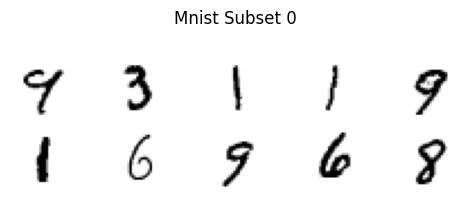

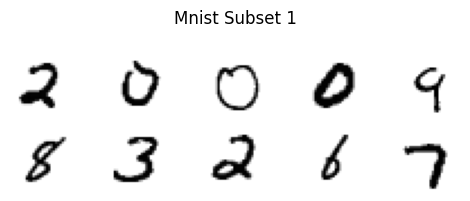

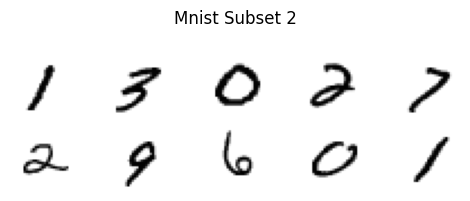

In [10]:
for i in range(3):
  plot_samples(next(iter(mnist_iid_train[i])), 0, title="Mnist Subset " + str(i),  n_examples=10)

6) Plot samples this time for non_iid data for 3 clients.

In [11]:
mnist_noniid_train, mnist_noniid_test = get_MNIST(type=NON_IID,
                                                  n_samples_train=200,
                                                  n_samples_test=100,
                                                  n_clients=3,
                                                  batch_size=25,)

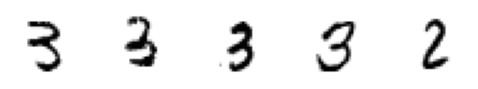

In [12]:
plot_samples(next(iter(mnist_noniid_train[0])), 0, n_examples=5)

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [13]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [14]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    q_difference_sum = 0
    for v1, v2 in zip(model_1.state_dict().values(), model_2.state_dict().values()):
      q_difference_sum += torch.pow(v1-v2, 2).sum()

    return q_difference_sum


In [15]:
model_1 = CNN()
model_2 = CNN()

print(difference_models_norm_2(model_0, model_1))
print(difference_models_norm_2(model_0, model_2))
print(difference_models_norm_2(model_1, model_2))

tensor(388.4667)
tensor(387.5005)
tensor(387.2959)


**Federated Optimization in Heterogeneous Networks**:<br><br>
$F_k(w) + \frac{\mu}{2} \cdot ||w_1, w_2||^2$ <br><br>

In Federated Learning, especially in heterogeneous networks, data distribution across clients (nodes) is usually non-iid, meaning that the data available at each client can be highly skewed or different. Heterogeneous networks also imply variations in computation and communication resources among the nodes.

- Local Optimization: Each client kk optimizes its local objectiveusing its data. The local objective combines the empirical risk and the regularization term, striking a balance between fitting the local data and maintaining model simplicity.

- Global Aggregation: After local optimization, the server aggregates the locally-computed models to form a global model. This global model is then sent back to the clients for the next round of federated optimization.

- Dealing with Heterogeneity: The regularization term helps in mitigating the challenges posed by the data and resource heterogeneity among the clients. It provides a form of structure to the optimization problem, helping the global model to generalize well across diverse local datasets.

Here is the function to perform one epoch of training data.

In [16]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss += mu/2*difference_models_norm_2(model, model_0)
        total_loss += loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [17]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    ### Copy model to a new variable ###
    model_cpy = deepcopy(model)

    local_loss = 0
    for epoch in range(epochs):
        local_loss = train_step(model, model_cpy, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [18]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [19]:
def average_models(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

FedProx follows this Iterative Learning:
1. Central server choose a statiscal server to be trained
2. Central server transmit the initial model to several nodes
3. Nodes train the model locally with thier own Data
4. Central server pools model result and generate one global mode without accessing any data

The step 2, 3 and 4 are repeated n_iterations

In [20]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model = deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss = local_learning(local_model, mu, local_optimizer,
                                        training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [21]:
global_model = CNN()
model, loss_hist, acc_hist = FedProx(global_model, mnist_iid_train,
                                     30, mnist_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3009812037150064 Server Test Accuracy: 12.333333333333332
====> i: 1 Loss: 2.2029852867126465 Server Test Accuracy: 25.0
====> i: 2 Loss: 0.28802305459976196 Server Test Accuracy: 84.66666666666666
====> i: 3 Loss: 0.10190783689419428 Server Test Accuracy: 90.66666666666666
====> i: 4 Loss: 0.0701430874566237 Server Test Accuracy: 93.0
====> i: 5 Loss: 0.04820622441669305 Server Test Accuracy: 91.0
====> i: 6 Loss: 0.06527843450506528 Server Test Accuracy: 92.33333333333333
====> i: 7 Loss: 0.05891038663685322 Server Test Accuracy: 91.66666666666666
====> i: 8 Loss: 0.019705377208689846 Server Test Accuracy: 92.33333333333333
====> i: 9 Loss: 0.040091660960266985 Server Test Accuracy: 92.33333333333333
====> i: 10 Loss: 0.01446913896749417 Server Test Accuracy: 92.33333333333333
====> i: 11 Loss: 0.008917556765178839 Server Test Accuracy: 91.66666666666666
====> i: 12 Loss: 0.0104300092013

2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

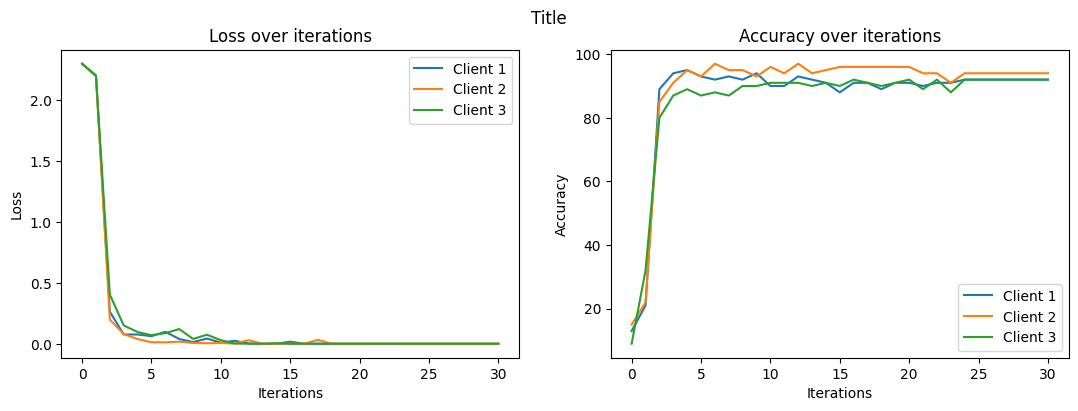

In [22]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
  iterations = range(1, len(loss_hist[0]) + 1)

  fig, axs = plt.subplots(1, 2, figsize=(13, 4))
  fig.suptitle(title)

  for i in range(len(loss_hist[-1])):
      loss = [loss_hist[k][i] for k in range(len(loss_hist))]
      axs[0].plot(loss, label=f'Client {i+1}')
  axs[0].set_xlabel('Iterations')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].set_title('Loss over iterations')

  for i in range(len(acc_hist[-1])):
      acc = [acc_hist[k][i] for k in range(len(loss_hist))]
      axs[1].plot(acc, label=f'Client {i+1}')
  axs[1].set_xlabel('Iterations')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].set_title('Accuracy over iterations')

  plt.show()

plot_acc_loss("Title", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [35]:
n_iter = 10
epochs = 10
lr = 0.1
mu = 0.3

model_prox = CNN()

final_model_prox, loss_hist_prox, acc_hist_prox = FedProx(model_prox, mnist_iid_train,
                                                          n_iter,  mnist_iid_test,
                                                          mu=mu,  epochs=epochs, lr=lr)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3029236793518066 Server Test Accuracy: 6.666666666666666
====> i: 1 Loss: 2.2978410720825195 Server Test Accuracy: 11.333333333333332
====> i: 2 Loss: 2.294583002726237 Server Test Accuracy: 13.666666666666664
====> i: 3 Loss: 2.2940467993418374 Server Test Accuracy: 13.666666666666664
====> i: 4 Loss: 2.2941396236419678 Server Test Accuracy: 13.666666666666664
====> i: 5 Loss: 2.2941083908081055 Server Test Accuracy: 13.666666666666664
====> i: 6 Loss: 2.2944390773773193 Server Test Accuracy: 13.666666666666664
====> i: 7 Loss: 2.2941168149312334 Server Test Accuracy: 13.666666666666664
====> i: 8 Loss: 2.294212023417155 Server Test Accuracy: 13.666666666666664
====> i: 9 Loss: 2.2941923936208086 Server Test Accuracy: 13.666666666666664
====> i: 10 Loss: 2.293981949488322 Server Test Accuracy: 13.666666666666664


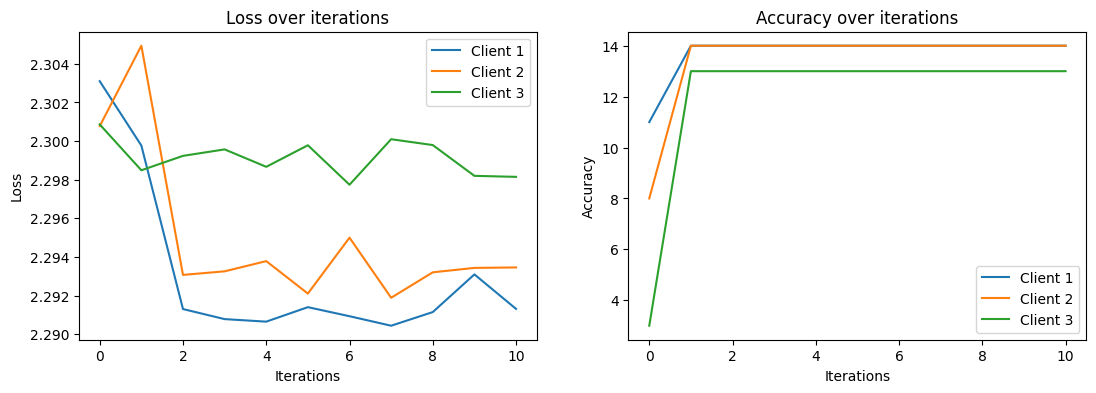

In [24]:
plot_acc_loss("", loss_hist_prox, acc_hist_prox)

4) What do you observe ?

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

Clients' weights: [0.2, 0.4, 0.4]
====> i: 0 Loss: 2.2903068542480467 Server Test Accuracy: 10.90909090909091
====> i: 1 Loss: 2.171509408950806 Server Test Accuracy: 8.0
====> i: 2 Loss: 1.5050316810607909 Server Test Accuracy: 47.27272727272727
====> i: 3 Loss: 3.600933521986008 Server Test Accuracy: 41.45454545454545
====> i: 4 Loss: 4.586222743988038 Server Test Accuracy: 42.90909090909091
====> i: 5 Loss: 1.282901978492737 Server Test Accuracy: 76.36363636363637
====> i: 6 Loss: 2.659669013391249 Server Test Accuracy: 64.72727272727272
====> i: 7 Loss: 2.123618376255035 Server Test Accuracy: 48.72727272727273
====> i: 8 Loss: 4.330848121643067 Server Test Accuracy: 39.27272727272727
====> i: 9 Loss: 3.4552775094984103 Server Test Accuracy: 48.72727272727273
====> i: 10 Loss: 1.8292920199222862 Server Test Accuracy: 59.676767676767675


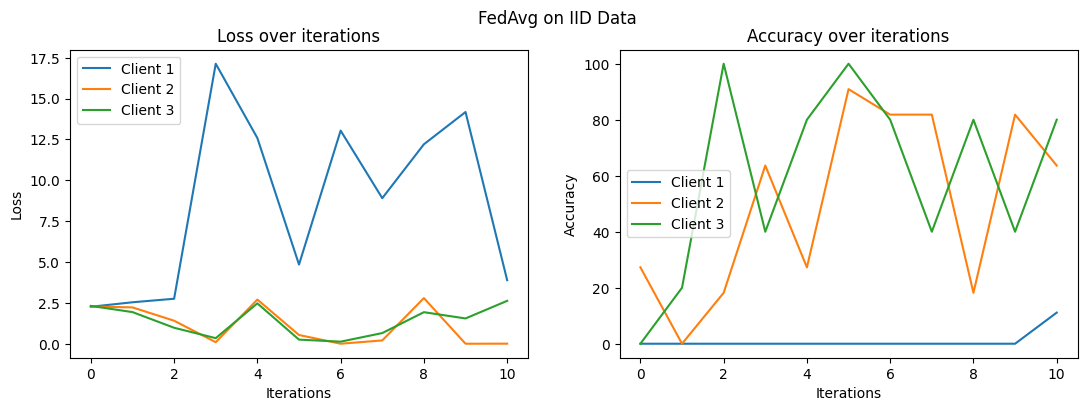

In [25]:
model = CNN()
final_model_avg, loss_hist_avg, acc_hist_avg = FedProx(model, mnist_noniid_train,
                                                       n_iter, mnist_noniid_test, mu=0,
                                                       epochs=20, lr=0.01)
plot_acc_loss('FedAvg on IID Data', loss_hist_avg, acc_hist_avg)

2) What do you observe ?

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [26]:
! pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=9bf6863af4526e7ff28578f7bdc9c8d9b55c8c6a2135c8096a1d270d097000c9
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Import medmnist

In [27]:
import medmnist

You can list all available datasets with this command

In [28]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [29]:
from medmnist import BloodMNIST

In [30]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [31]:
pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [32]:
train_dataset = BloodMNIST(root='./', split='train', download=True, transform=pipeline)
test_dataset = BloodMNIST(root='./', split='test', download=True, transform=pipeline)

100%|██████████| 35461855/35461855 [00:54<00:00, 651484.62it/s] 


Using downloaded and verified file: ./bloodmnist.npz


In [85]:
train_dataset.info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

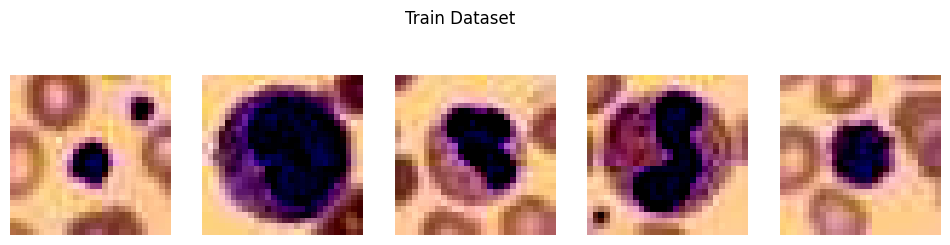

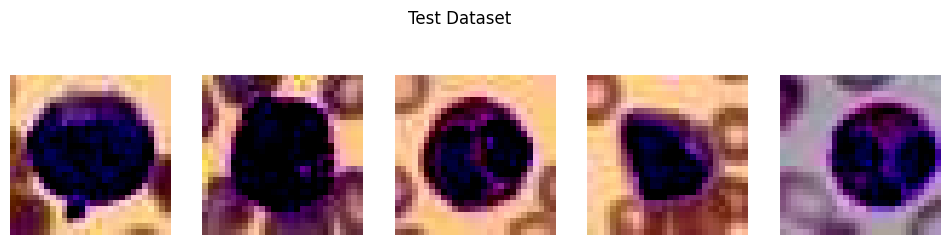

In [33]:
def plot_dataset(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        index = np.random.randint(len(dataset))
        img, label = dataset[i]
        img = img.permute(1, 2, 0)
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title)
    plt.show()

plot_dataset(train_dataset, 'Train Dataset')
plot_dataset(test_dataset, 'Test Dataset')

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [34]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [34]:
def non_iid_split2():
  pass

In [37]:
def get_BLOOD(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    pipeline = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dataset = BloodMNIST(root='./', split='train', download=True, transform=pipeline)
    test_dataset = BloodMNIST(root='./', split='test', download=True, transform=pipeline)

    if (type == "iid"):
      train = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
      test = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else :
      train = non_iid_split2(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
      test = non_iid_split2(test_dataset, n_clients, n_samples_test, batch_size, shuffle)

    return train, test


blood_iid_train, blood_iid_test = get_BLOOD(n_samples_train=200, n_samples_test=100,
                                            n_clients=3, batch_size=25,)

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


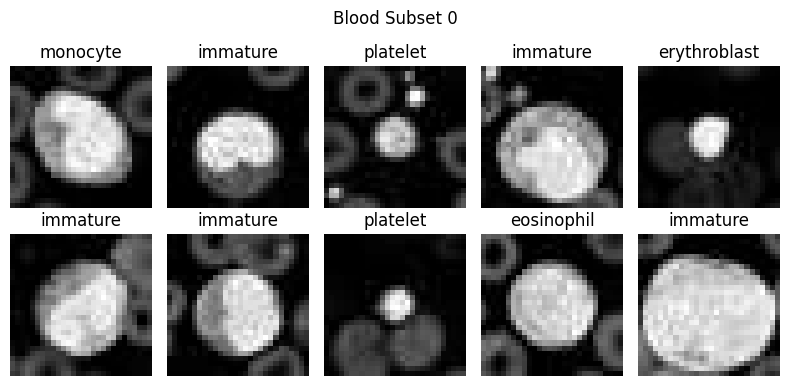

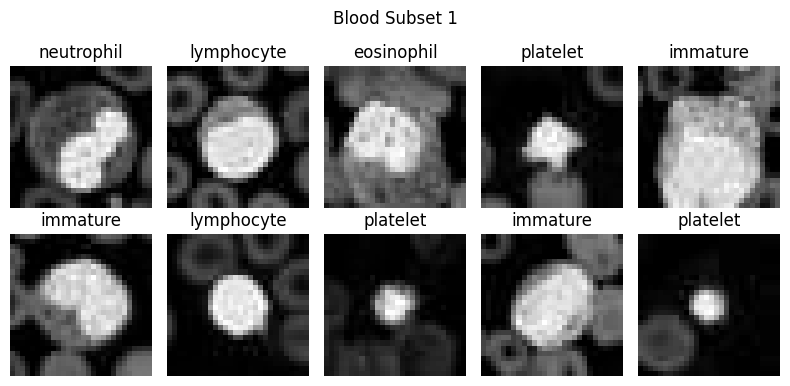

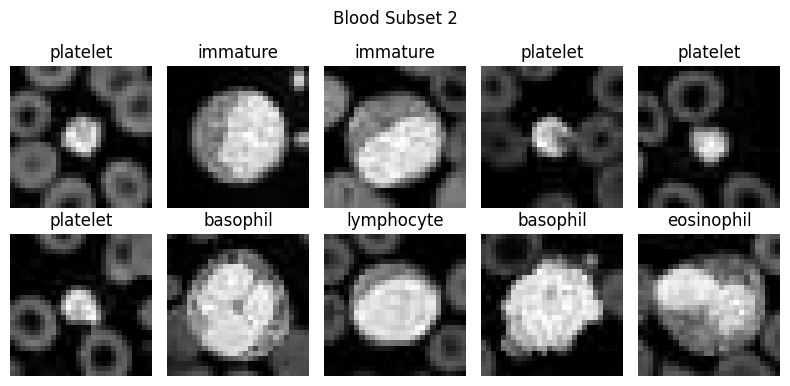

In [82]:
def plot_samples2(data, channel:int, title=None, plot_name="", n_examples =20):
    n_rows = int(n_examples / 5)
    plt.figure(figsize=(8, 2*n_rows))
    if title:
      plt.suptitle(title)

    X, y = data
    class_names = list(train_dataset.info['label'].items())

    for idx in range(n_examples):
        ax = plt.subplot(n_rows, 5, idx + 1)
        name = class_names[y[idx].item()][1].split()[0]
        ax.set_title(name)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap="gray")
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

for i in range(3):
  plot_samples2(next(iter(blood_iid_train[i])), 0, title="Blood Subset " + str(i),  n_examples=10)

### Exercice 6 : Use federated learning on medical data

### IID data

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [89]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes: int):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [90]:
nbr_classe = len(train_dataset.info['label'])
nbr_classe

8

In [91]:
custom_model = CustomCNN(nbr_classe)
model, loss_hist, acc_hist = FedProx(custom_model, blood_iid_train,
                                     20, blood_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


RuntimeError: ignored

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf